# -----------------------------> Linear Regression & Graphs <------------------------------

# Dependencies & Libraries

In [1]:
# Warning Suppression https://pymotw.com/2/warnings/ 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Bring in dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from sqlalchemy import create_engine

In [6]:
# For ensemble calculations
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.metrics import classification_report_imbalanced
from sklearn.decomposition import PCA
import hvplot.pandas
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Read in data and perform basic data review

In [7]:
### Configure settings for Relational Database Service, and defining database info in config variable.
jdbc_url="jdbc:postgresql://34.67.52.115/team5k"
config = {'user': 'postgres', 
          "password": "team5kteam5k", 
          "driver":"org.postgresql.Driver",
          "location": "34.67.52.115",
          "db": "team5k",
          "port": "5432"}

In [8]:
### Creating variable holding postgres info in format "postgres://[user]:[password]@[location]:[port]/[database]".
create_engine_str = ('postgresql://' 
                     + config["user"] 
                     + ":" + config["password"] 
                     + "@" + config["location"] 
                     + ":" + config["port"] 
                     + "/" + config["db"])

In [10]:
# Connecting to Postgres instance.
engine = create_engine(create_engine_str)

In [11]:
# Printing info for table names. 
print (engine.table_names())

['committees', 'candidates', 'education', 'six_state_donations', 'res_lr', 'res_log', 'donations', 'health_metrics', 'agg_county_votes', 'birth_death_rate', 'postal_codes', 'agg_county_donors', 'pres_votes_6t', 'unemployment']


In [12]:
### Get voter data
votes_df = pd.read_sql_query('select * from "agg_county_votes"',con=engine)
votes_df

,index,blue_votes,red_votes,other_votes,total_votes,county,state,election_year,PopPct_Urban,Unemployment,PopDen_Urban,PopPct_Rural,PopDen_Rural,winning_party
0,0,13025,5947,484.0,19456.0,Apache,AZ,2000,25.94,9.0,1080.7,74.06,4.7,democrat
1,1,13360,18180,1701.0,33241.0,Cochise,AZ,2000,63.70,4.5,1933.4,36.30,7.8,republican
2,2,20280,17562,3041.0,40883.0,Coconino,AZ,2000,68.53,4.4,1939.8,31.47,2.3,democrat
3,3,7700,9158,878.0,17736.0,Gila,AZ,2000,58.94,5.2,1625.0,41.06,4.6,republican
4,4,3355,6007,302.0,9664.0,Graham,AZ,2000,53.56,5.4,1430.2,46.44,3.8,republican
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,67,79200,142521,17321.0,239042.0,Waukesha,WI,2016,90.14,3.4,1314.5,9.86,136.2,republican
2016,68,8440,16189,1395.0,26024.0,Waupaca,WI,2016,35.06,3.9,1606.2,64.94,46.2,republican
2017,69,3792,7669,538.0,11999.0,Waushara,WI,2016,10.50,5.0,1403.6,89.50,35.1,republican
2018,70,37054,43448,6642.0,87144.0,Winnebago,WI,2016,86.57,3.6,2269.9,13.43,60.5,republican


In [13]:
#votes_df.drop(['index'], axis=1)

In [14]:
# Index of column names in the Aggregate Votes dataset
votes_df.columns

Index(['index', 'blue_votes', 'red_votes', 'other_votes', 'total_votes',
       'county', 'state', 'election_year', 'PopPct_Urban', 'Unemployment',
       'PopDen_Urban', 'PopPct_Rural', 'PopDen_Rural', 'winning_party'],
      dtype='object')

# Data Exploration & Graphs

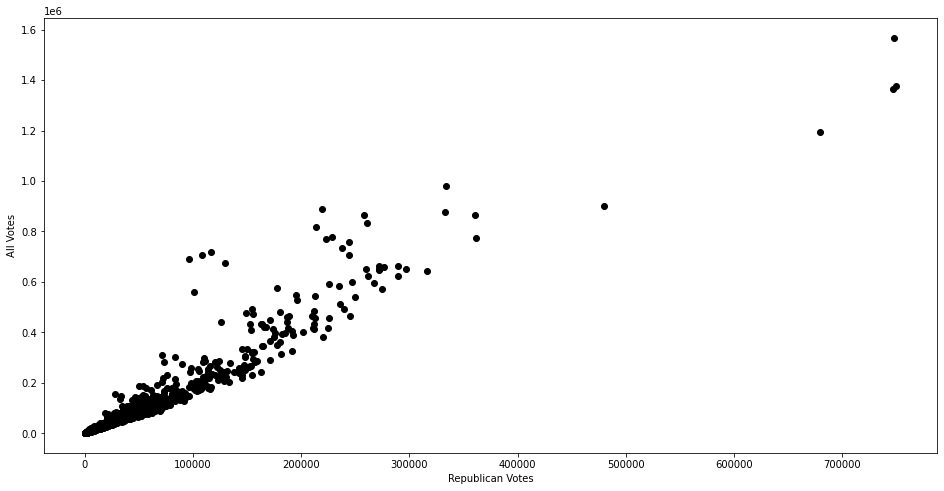

In [15]:
plt.figure(figsize=(16, 8))
plt.scatter(
    votes_df['red_votes'],
    votes_df['total_votes'],
    c='black'
)
plt.xlabel("Republican Votes")
plt.ylabel("All Votes")
plt.show()

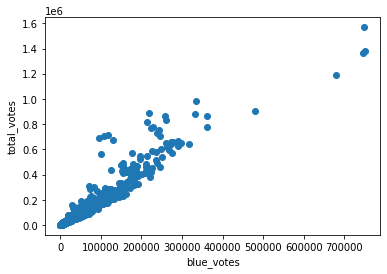

In [16]:
# Replubican votes compared to all votes
plt.scatter(votes_df.red_votes, votes_df.total_votes)
plt.xlabel('blue_votes')
plt.ylabel('total_votes')
plt.show()

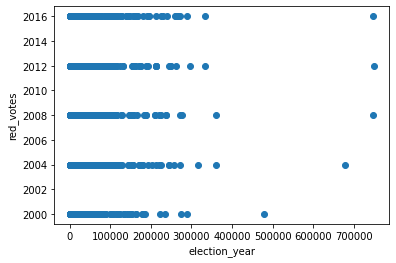

In [32]:
# Replubican votes by election year
plt.scatter(votes_df.red_votes, votes_df.election_year)
plt.xlabel('election_year')
plt.ylabel('red_votes')
plt.show()

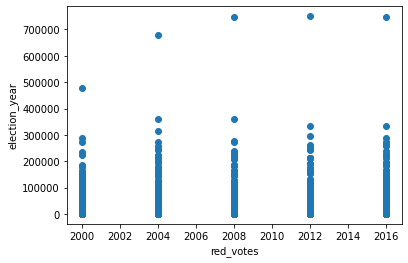

In [33]:
# Replubican votes by election year
plt.scatter(votes_df.election_year, votes_df.red_votes)
plt.xlabel('red_votes')
plt.ylabel('election_year')
plt.show()

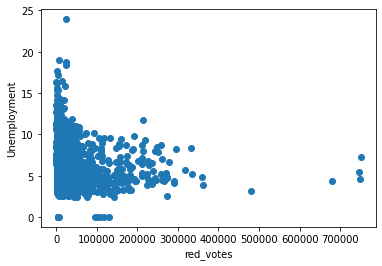

In [19]:
# Replubican votes compared to unemployment rate
plt.scatter(votes_df.red_votes, votes_df.Unemployment)
plt.xlabel('red_votes')
plt.ylabel('Unemployment')
plt.show()

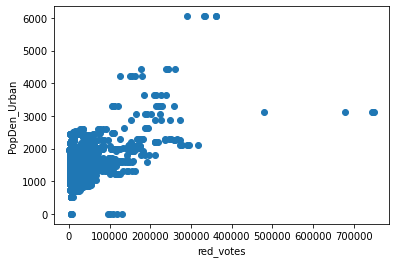

In [20]:
# Replubican votes compared to urban population density
plt.scatter(votes_df.red_votes, votes_df.PopDen_Urban)
plt.xlabel('red_votes')
plt.ylabel('PopDen_Urban')
plt.show()

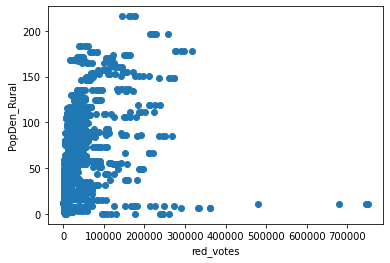

In [21]:
# Replubican votes compared to rural population density
plt.scatter(votes_df.red_votes, votes_df.PopDen_Rural)
plt.xlabel('red_votes')
plt.ylabel('PopDen_Rural')
plt.show()

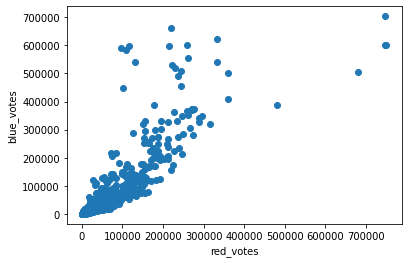

In [22]:
# Replubican votes compared to rural population density
plt.scatter(votes_df.red_votes, votes_df.blue_votes)
plt.xlabel('red_votes')
plt.ylabel('blue_votes')
plt.show()

# Create X/y for features & model

In [23]:
# Create our features
X = votes_df.copy()
X = X.drop("red_votes", axis=1)
X.head()

,index,blue_votes,other_votes,total_votes,county,state,election_year,PopPct_Urban,Unemployment,PopDen_Urban,PopPct_Rural,PopDen_Rural,winning_party
0,0,13025,484.0,19456.0,Apache,AZ,2000,25.94,9.0,1080.7,74.06,4.7,democrat
1,1,13360,1701.0,33241.0,Cochise,AZ,2000,63.70,4.5,1933.4,36.30,7.8,republican
2,2,20280,3041.0,40883.0,Coconino,AZ,2000,68.53,4.4,1939.8,31.47,2.3,democrat
3,3,7700,878.0,17736.0,Gila,AZ,2000,58.94,5.2,1625.0,41.06,4.6,republican
4,4,3355,302.0,9664.0,Graham,AZ,2000,53.56,5.4,1430.2,46.44,3.8,republican


In [24]:
# Create our target, y-could also be set up as a series nested inside a df. Check "loc" feature https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
y = votes_df['red_votes']
y[:5]
#y.describe()
#y.head

0     5947
1    18180
2    17562
3     9158
4     6007
Name: red_votes, dtype: int64

In [25]:
# Change all columns, in X variable, to numeric values
X = pd.get_dummies(['county', 'state', 'election_year','unemployment','PopPct_Urban','PopDen_Urban'])

In [26]:
X

,PopDen_Urban,PopPct_Urban,county,election_year,state,unemployment
0,0,0,1,0,0,0
1,0,0,0,0,1,0
2,0,0,0,1,0,0
3,0,0,0,0,0,1
4,0,1,0,0,0,0
5,1,0,0,0,0,0


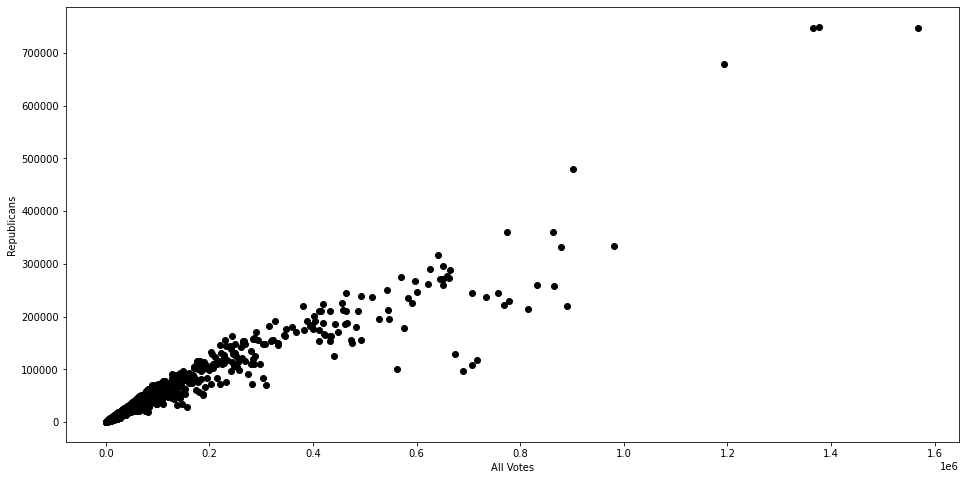

In [27]:
plt.figure(figsize=(16, 8))
plt.scatter(
    votes_df['total_votes'],
    votes_df['red_votes'],
    c='black'
)
plt.xlabel("All Votes")
plt.ylabel("Republicans")
plt.show()

In [28]:
X = votes_df['Unemployment'].values.reshape(-1,1)
y = votes_df['PopDen_Rural'].values.reshape(-1,1)

reg = LinearRegression()
reg.fit(X, y)

print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))

The linear model is: Y = 76.293 + -2.8423X


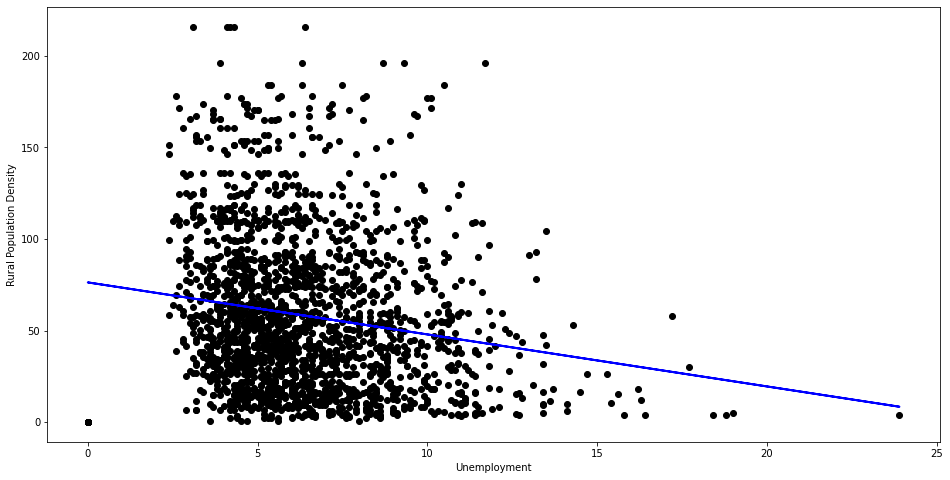

In [29]:
predictions = reg.predict(X)

plt.figure(figsize=(16, 8))
plt.scatter(
    votes_df['Unemployment'],
    votes_df['PopDen_Rural'],
    c='black'
)
plt.plot(
    votes_df['Unemployment'],
    predictions,
    c='blue',
    linewidth=2
)
plt.xlabel("Unemployment")
plt.ylabel("Rural Population Density")
plt.show()

In [30]:
X = votes_df['Unemployment']
y = votes_df['PopDen_Rural']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

#X = votes_df['Unemployment'].values.reshape(-1,1)
#y = votes_df['PopDen_Rural'].values.reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:           PopDen_Rural   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     57.90
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           4.20e-14
Time:                        06:20:09   Log-Likelihood:                -10376.
No. Observations:                2020   AIC:                         2.076e+04
Df Residuals:                    2018   BIC:                         2.077e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           76.2932      2.542     30.018   

### End